In [49]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import os

from sklearn.model_selection import train_test_split

os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'

In [37]:
# Read and clean the data
df_places = pd.read_csv('./data/tourism_with_id.csv')
df_places = df_places.drop(['Coordinate', 'Unnamed: 11', 'Unnamed: 12'], axis=1)

df_reviews = pd.read_csv('./data/tourism_rating.csv')
df_reviews['User_Id'] = df_reviews['User_Id'] - 1
df_reviews['Place_Id'] = df_reviews['Place_Id'] - 1

In [1]:
# Sanity_check (Users from 0-9 and places with the following id)
#df = df_reviews.copy()
place_ids = [87, 207, 3, 165, 320, 201, 300, 29, 104, 66]

df = df_reviews[(df_reviews['User_Id'] < 10) & (df_reviews['Place_Id'].isin(place_ids))]
df['Place_Id'] = df.groupby(['Place_Id']).ngroup()

df2 = df_places[df_places['Place_Id'].isin(place_ids)]
df2['Place_Id'] = df2.groupby(['Place_Id']).ngroup()
df2['Category'] = df2.groupby(['Category']).ngroup()

df = df.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df = pd.merge(df, df2, on='Place_Id', how='inner')

NameError: name 'df_reviews' is not defined

In [53]:
# Sanity check 2
df = df_reviews[(df_reviews['User_Id'] < 120) & (df_reviews['Place_Id'] < 100)]

In [54]:
num_users = df['User_Id'].nunique()
num_places = df['Place_Id'].nunique()
num_categories = 20
num_samples = 1000
num_burnin = 800
num_chains = 4
num_cores = 4

In [50]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [55]:
observed_ratings = np.zeros((num_users, num_places))

for _, row in df.iterrows():
    observed_ratings[row['User_Id']][row['Place_Id']] = row['Place_Ratings'] #  + rating_std

In [56]:
a = c = 0.15
a_prime = c_prime = 0.30
b_prime = d_prime = 0.15

In [57]:
observed_ratings.shape

(120, 100)

In [46]:
with pm.Model() as model:

    # User activity
    xi = pm.Gamma('xi', alpha=a_prime, beta=a_prime/b_prime, shape=(num_users, 1))

    # User preferences
    theta = pm.Gamma('theta', alpha=a, beta=xi, shape=(num_users, num_categories))

    # Place popularity
    eta = pm.Gamma('eta', alpha=c_prime, beta=c_prime/d_prime, shape=(num_places, 1))

    # Place attributes
    beta = pm.Gamma('beta', alpha=c, beta=eta, shape=(num_places, num_categories))

    # Ratings
    y_ui = pm.Poisson('y_ui', mu=pm.math.dot(theta, beta.T), observed=observed_ratings)

In [47]:
# Fit the model
with model:
    # trace = pm.sample(1000, tune=1000, chains=1, cores=8, nuts={'target_accept': 0.9})
    #step = pm.Metropolis()
    trace = pm.sample(num_samples, tune=num_burnin, chains=num_chains, cores=num_cores) #step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xi, theta, eta, beta]


KeyboardInterrupt: 

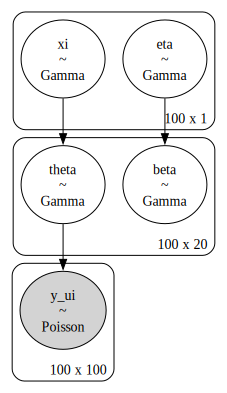

In [37]:
pm.model_to_graphviz(model)

In [15]:
# Extract the posterior samples
#xi_samples = np.concatenate([sublist for sublist in trace['posterior']['xi']], axis=0)
#eta_samples = np.concatenate([sublist for sublist in trace['posterior']['eta']], axis=0)
theta_samples = np.concatenate([sublist for sublist in trace['posterior']['theta']], axis=0)
beta_samples = np.concatenate([sublist for sublist in trace['posterior']['beta']], axis=0)

In [24]:
prediction_ratings = np.zeros((num_users, num_places))

In [25]:
len_df = len(df)
len_samples = len(theta_samples)

for index, row in enumerate(df.iterrows()):
    user_id = int(row[1]['User_Id'])
    place_id = int(row[1]['Place_Id'])
    ratings = []

    for i in range(len_samples):
        theta_sample = theta_samples[i]
        beta_sample = beta_samples[i]

        #rating = np.random.poisson(lam=np.dot(theta_sample[user_id], beta_sample[place_id].T))
        rating = np.dot(theta_sample[user_id], beta_sample[place_id].T)
        ratings.append(rating)

    prediction_ratings[user_id][place_id] = np.mean(ratings)

In [32]:
def RMSE(predictions, data):
    total_error = 0

    for _, row in data.iterrows():
        user_id = int(row['User_Id'])
        place_id = int(row['Place_Id'])

        predicted_rating = predictions[user_id][place_id]
        error = (predicted_rating - row['Place_Ratings'] + 1) ** 2
        total_error += error
    
    return np.sqrt(total_error / data.shape[0])

In [33]:
RMSE(prediction_ratings, df)

1.5225956958647544

In [35]:
for i in prediction_ratings: print(i + 1)

[1.         1.         1.         1.         2.71913339 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.6863687  1.         1.         1.
 1.         2.28959104 2.00144698 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         2.07559068 1.
 1.         1.         1.         1.         1.         1.99156549
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 2.52392874 1.         1.         1.         1.         1.
 1.         1.         1.         1.40549986 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         2.23247848 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.5

- RMSE -> 1.6423444034407002 for all gamma variables 0.3, k = 20, 10 users, 10 places (NUTS)
- RMSE -> 2.6278700252165326 for all gamma variables 0.3, k = 10, 100 users, 100 places (NUTS)
- RMSE -> 2.694379213061253 for all gamma variables 0.3, k = 10, 100 users, 100 places (METROPOLIS)
- RMSE -> 2.412314310106774 for all gamma variables 0.3, k = 20, 100 users, 100 places (NUTS)
- RMSE -> 2.3887861669229777 for 0.3, 2.0, k = 20, 100 users, 100 places (NUTS)
- RMSE -> 2.253403694899695 for 0.15, 1.0, k = 20, 100 users, 100 places (NUTS)
- RMSE -> 2.235817688020334 for 0.15, 2.0, k = 20, 100 users, 100 places (NUTS)
- RMSE -> 1.3807776734505475 for 0.15, 2.0, k = 20, 100 users, 100 places (NUST) (matrix was initialized with )